# paper: FRB 220319aaeb (SNR42, nearby)|

In [4]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn, sgram_fn_vec, sgram_fn, gauss, gauss_norm, model_free_4, model_free_normalized_4, power_law # pulse_fn_vec  
from burstfit.utils.plotter import plot_fit_results, plot_2d_fit 
from burstfit.io import BurstIO
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
# use Liam's function to read in filterbank files 
import sys
sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

 
%matplotlib inline 

def prepare_bd(candidate, dm_heimdall, width_heimdall, snr_heimdall, mask_chans=[], datestring=None, beam=None, corr=None, fil_file=None, voltage = False):
    if voltage: 
        fil_file = fil_file
    else: 
        fil_file ='/data/dsa110/T1/'+corr + '/' + datestring + '/fil_'+candidate+'/'+candidate+'_'+str(beam)+'.fil'
    
    logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
    logging.basicConfig(
        level=logging.INFO,
        format=logging_format,
    )
    
    bd = BurstData(
    fp=fil_file,
    dm=dm_heimdall ,
    tcand=0.5, # pulse starting time in s.
    width=width_heimdall,  
    snr=snr_heimdall
    )

    bd.prepare_data(mask_chans = mask_chans)
    
    return bd 




# input variables 
candidate = '220319aaeb'
dm_heimdall = 111
width_heimdall = 1 
snr_heimdall = 41.7

datestring = '2022_2_6_19_34_4'
beam = 172
corr = 'corr09'
fil_file = '/home/ubuntu/vikram/scratch/220319aaeb.fil'

mask_chans=[] 

bd = prepare_bd(candidate, dm_heimdall, width_heimdall, snr_heimdall, datestring=datestring, beam=beam, corr=corr, fil_file=fil_file, voltage=True)


2022-05-26 18:53:26,522 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-05-26 18:53:27,176 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-05-26 18:53:27,179 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-05-26 18:53:27,182 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (masked, masked)


## de-disperse data (or read from file) and chop near the burst time

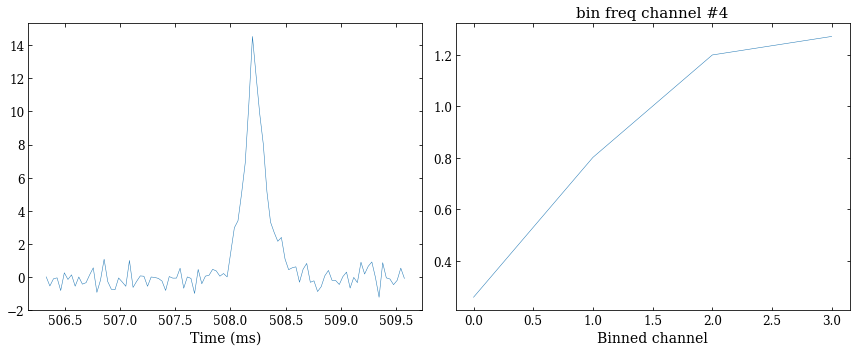

In [5]:
def prepare_burst_data(filterbank, candidate, bd, t_chop_center_s = 0.5, t_chop_width = 50, dedisperse=False, nfreq = 4):
    
    # save the de-dispersed data to file (de-dispersion takes long time)
    if dedisperse:
        data = ff.proc_cand_fil(filterbank, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
        np.save('%s_%d.txt'%(candidate, nfreq), data, allow_pickle=False)
    else: 
        data = np.load('%s_%d.txt.npy'%(candidate, nfreq)) 
    
    
    i_low = int(t_chop_center_s / bd.tsamp - t_chop_width * bd.width)
    i_high = int(t_chop_center_s / bd.tsamp + t_chop_width * bd.width)
    
    t_burst = [i * bd.tsamp * 1e3 for i in range(i_low, i_high)]
    data_burst = data[:, i_low: i_high] 

    fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5)) 
    ax1[0].plot(t_burst, data_burst.mean(0))
    ax1[0].set_xlabel('Time (ms)')
    ax1[1].plot(data_burst.mean(1))
    ax1[1].set_xlabel('Binned channel')
    ax1[1].set_title('bin freq channel #%d'%nfreq)
    plt.tight_layout()
    
    
    return data_burst




data_burst = prepare_burst_data(fil_file, candidate, bd, t_chop_center_s=0.508, t_chop_width = 50)

## Fit, select model, spectrum autocorrlation

In [41]:
def fit_paper_curvefit(data_2d, pnames, pulse_Model, profile_bounds, snames, spectra_Model, nfreq = 4, fix_ncomp=False, ncomp=1, plot=True):
    ncomp = ncomp
    pnames = pnames 
    pulseModel = Model(pulse_Model, param_names=pnames)
    spectraModel = Model(spectra_Model, param_names=snames)
    sgram_mask = np.full(np.shape(data_2d), False)
    sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)
    
    bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_2d, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1,
    )
    
    bf.validate()
    bf.precalc()
    #bf.initial_profilefit(bounds = profile_bounds, plot = plot)
    #bf.initial_spectrafit(plot = plot)

    #bf.fitcycle(plot=plot) # fit for one component.
    bf.fitall(plot=plot, fix_ncomp = fix_ncomp, ncomp = ncomp) # fit all componnts 
    print('{bf}.calc_redchisq()=', bf.calc_redchisq())


    # plot_fit_results(bf_S1T2_c1.sgram, bf_S1T2_c1.sgram_model.evaluate, bf_S1T2_c1.sgram_params['all'][1]['popt'], 
    #                  bf_S1T2_c1.tsamp, bf_S1T2_c1.fch1, bf_S1T2_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
    #dm_fit, dm_fit_err = bf_S1T2_c1.sgram_params['all'][1]['popt'][-1], bf_S1T2_c1.sgram_params['all'][1]['perr'][-1]

    return bf 


def fit_paper_mcmc_bic(bf, mcmc=True, nwalkers = 60, nsteps = 5000, n_param_overlap = 0):
    mcmc_kwargs = {'nwalkers':nwalkers, 'nsteps':nsteps,
               'skip':500, 'ncores':4, 
               'start_pos_dev':0.01,
               'prior_range':0.8, 
               'save_results':True,
               'outname':'test_file'}

    if mcmc:
        bf.run_mcmc(plot=True, **mcmc_kwargs)
    
    n_model_param = bf.comp_num * len(bf.param_names) - n_param_overlap 
    n_data = bf.nt * bf.nf 
    model_param = []
    for i in range(1, bf.comp_num + 1):
        model_param += bf.sgram_params['all'][i]['popt'] 

    lnL = bf.mcmc.lnlk(model_param)
    bf.BIC(lnL, n_model_param, n_data)
    print('{bf}.bic = ', bf.bic) 
    
    return 0


def select_model(bf_name_list):
    bic_list = []
    for name in bf_name_list:
        bf = globals()[name]
        bic_list = np.append(bic_list, bf.bic)
        
    return [x for _,x in sorted(zip(bic_list, bf_name_list))], bic_list


def autocorrelation():
    pass

self.function_input_names:  ['S', 'mu', 'sigma']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-26 18:53:51,320 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 18:53:51,323 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 18:53:51,326 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-26 18:53:51,328 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-26 18:53:51,331 - tests -root - INFO - P values: T-test (0.35209), Kruskal (0.24800), KS (0.28267), F-test (0.08019)
2022-05-26 18:53:51,333 - run_tests -burstfit.fit - INFO - On pulse residual is similar to left off pulse region.
2022-05-26 18:53:51,335 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-26 18:53:51,338 - tests -root - INFO - P values: T-test (0.79841), Kruskal (0.59951), KS (0.66014), F-test (0.34593)
2022-05-26 18:53:51,340 - run_tests -burstfit.fit - INFO - On pulse residual is similar to right off pulse region.
2022-0

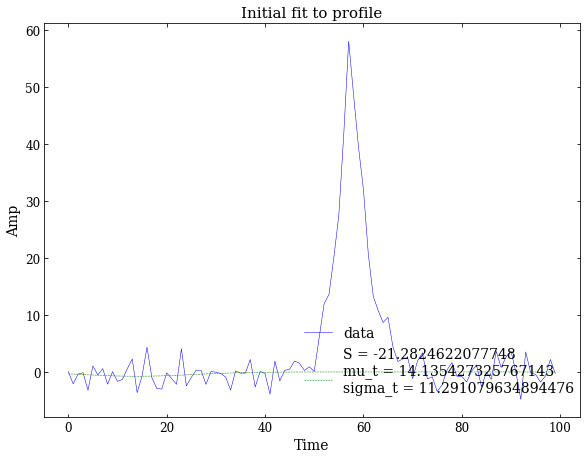

2022-05-26 18:53:51,543 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-26 18:53:51,547 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7ff3f19cad90>
[0.31438667 0.3127249  0.27377236 0.5126187 ]


2022-05-26 18:53:51,554 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-26 18:53:51,556 - initial_spectrafit -burstfit.fit - INFO - c0: 0.31438666582107544 +- 0.0
2022-05-26 18:53:51,557 - initial_spectrafit -burstfit.fit - INFO - c1: 0.31272488832473755 +- 0.0
2022-05-26 18:53:51,558 - initial_spectrafit -burstfit.fit - INFO - c2: 0.27377235889434814 +- 0.0


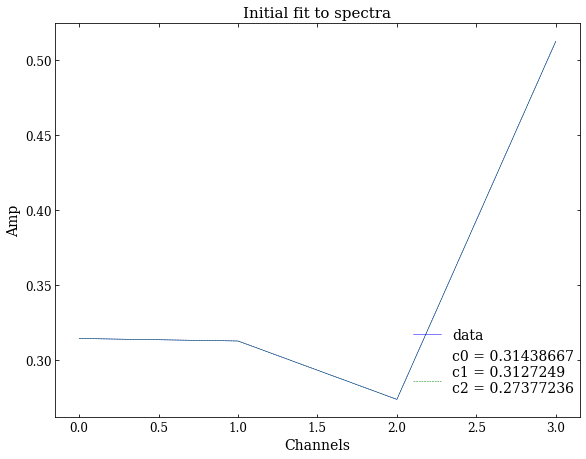

2022-05-26 18:53:51,736 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-26 18:53:51,739 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.31438667, 0.3127249, 0.27377236, -21.2824622077748, 14.135427325767143, 11.291079634894476, 111]
2022-05-26 18:53:51,771 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-26 18:53:51,773 - sgram_fit -burstfit.fit - INFO - c0: 0.32502678097567883 +- 1.670060037638263
2022-05-26 18:53:51,775 - sgram_fit -burstfit.fit - INFO - c1: 0.2887174539834208 +- 1.3646012464858004
2022-05-26 18:53:51,778 - sgram_fit -burstfit.fit - INFO - c2: -0.006096097079387117 +- 1.41539117006164
2022-05-26 18:53:51,780 - sgram_fit -burstfit.fit - INFO - S: -9.142646876751956 +- 11.611359708012241
2022-05-26 18:53:51,782 - sgram_fit -burstfit.fit - INFO - mu_t: 16.09376131403886 +- 12.68996901896637
2022-05-26 18:53:51,784 - sgram_fit -burstfit.fit - INFO - sigma_t: 6.749036623924817 +- 7.3940109899

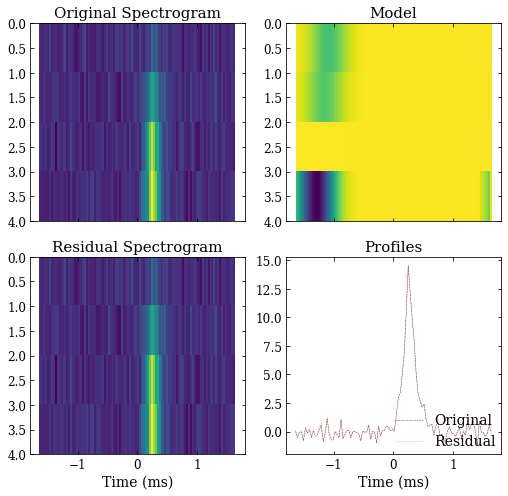

2022-05-26 18:53:52,204 - model -burstfit.fit - INFO - Making model.
2022-05-26 18:53:52,207 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 18:53:52,210 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 18:53:52,213 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-26 18:53:52,215 - model -burstfit.fit - INFO - Making model.
2022-05-26 18:53:52,217 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 18:53:52,220 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.8112241397482118
2022-05-26 18:53:52,221 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 18:53:52,223 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 18:53:52,226 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-26 18:53:52,229 - run

{bf}.calc_redchisq()= 0.8112241397482118


In [7]:
bf_S1T1_c1 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t'], gauss, 
          [(0, 50, 0),(np.inf, 60, 5*bd.width)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, ncomp=1, plot=True)

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-26 19:30:16,678 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 19:30:16,681 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 19:30:16,686 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-26 19:30:16,688 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-26 19:30:16,692 - tests -root - INFO - P values: T-test (0.35209), Kruskal (0.24800), KS (0.28267), F-test (0.08019)
2022-05-26 19:30:16,694 - run_tests -burstfit.fit - INFO - On pulse residual is similar to left off pulse region.
2022-05-26 19:30:16,695 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-26 19:30:16,699 - tests -root - INFO - P values: T-test (0.79841), Kruskal (0.59951), KS (0.66014), F-test (0.34593)
2022-05-26 19:30:16,701 - run_tests -burstfit.fit - INFO - On pulse residual is similar to right off pulse region.
2022-0

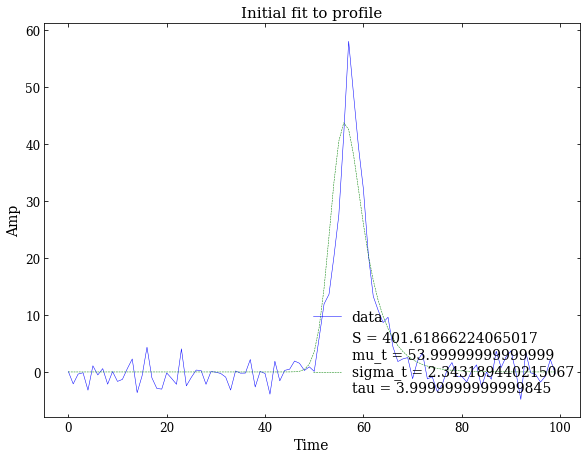

2022-05-26 19:30:16,917 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-26 19:30:16,920 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7ff3f19cad90>
[0.08549967 0.27269894 0.43279794 0.50350654]


2022-05-26 19:30:16,926 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-26 19:30:16,928 - initial_spectrafit -burstfit.fit - INFO - c0: 0.08549966663122177 +- 0.0
2022-05-26 19:30:16,930 - initial_spectrafit -burstfit.fit - INFO - c1: 0.27269893884658813 +- 0.0
2022-05-26 19:30:16,932 - initial_spectrafit -burstfit.fit - INFO - c2: 0.43279793858528137 +- 0.0


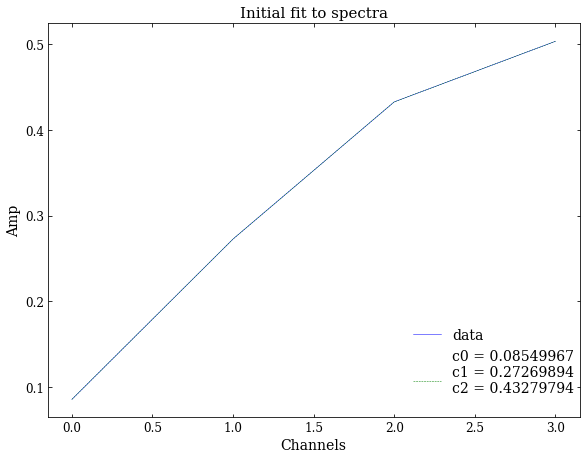

2022-05-26 19:30:17,096 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-26 19:30:17,098 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.08549967, 0.27269894, 0.43279794, 401.61866224065017, 53.99999999999999, 2.343189440215067, 3.9999999999999845, 111]
2022-05-26 19:30:17,268 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-26 19:30:17,270 - sgram_fit -burstfit.fit - INFO - c0: 0.09596833097525385 +- 0.012204508261721635
2022-05-26 19:30:17,273 - sgram_fit -burstfit.fit - INFO - c1: 0.2768666838072259 +- 0.01075549537638858
2022-05-26 19:30:17,275 - sgram_fit -burstfit.fit - INFO - c2: 0.4380179567016678 +- 0.010402486612516365
2022-05-26 19:30:17,278 - sgram_fit -burstfit.fit - INFO - S: 319.55386430320664 +- 3.528268069017978
2022-05-26 19:30:17,280 - sgram_fit -burstfit.fit - INFO - mu_t: 55.82603013641112 +- 0.2392820578440146
2022-05-26 19:30:17,282 - sgram_fit -burstfit.fit - INFO - sigma_t: 2.389055

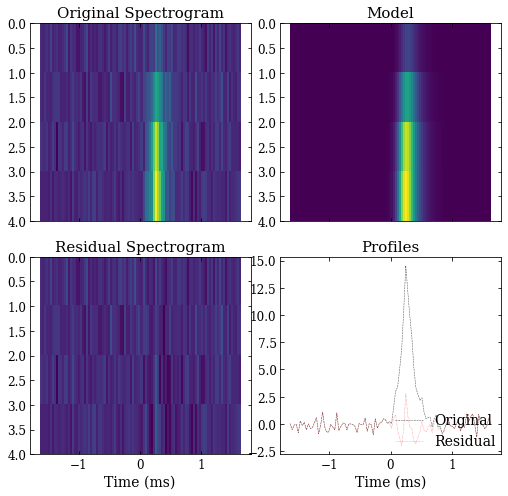

2022-05-26 19:30:17,681 - model -burstfit.fit - INFO - Making model.
2022-05-26 19:30:17,684 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 19:30:17,687 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 19:30:17,689 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-26 19:30:17,691 - model -burstfit.fit - INFO - Making model.
2022-05-26 19:30:17,693 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 19:30:17,696 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.4815666350582255
2022-05-26 19:30:17,697 - fitall -burstfit.fit - INFO - Fixed component exceeded. Terminated individual component fitting.
2022-05-26 19:30:17,699 - fitall -burstfit.fit - INFO - Final number of components = 1. Terminating fitting.
2022-05-26 19:30:17,701 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to

{bf}.calc_redchisq()= 1.4815666350582255


In [29]:
bf_S1T2_c1 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t', 'tau'], pulse_fn, 
          [(0, 45, 0, 0),(np.inf, 65, 10*bd.width, np.inf)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, fix_ncomp = True, ncomp=1, plot=True)

2022-05-26 19:30:42,408 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-26 19:30:42,413 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [9.59683310e-02 2.76866684e-01 4.38017957e-01 3.19553864e+02
 5.58260301e+01 2.38905575e+00 3.26225321e+00 1.10454891e+02]
2022-05-26 19:30:42,423 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-26 19:30:42,426 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-05-26 19:30:42,428 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-26 19:30:42,430 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(5.872055780281991) + max_sigma_t_prior(4.3003003496260845))
2022-05-26 19:30:42,432 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its max value of prior to 500*max(ts)*

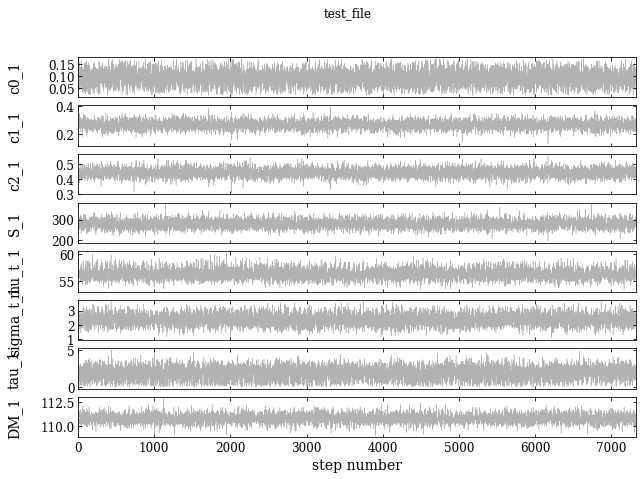

<Figure size 432x288 with 0 Axes>

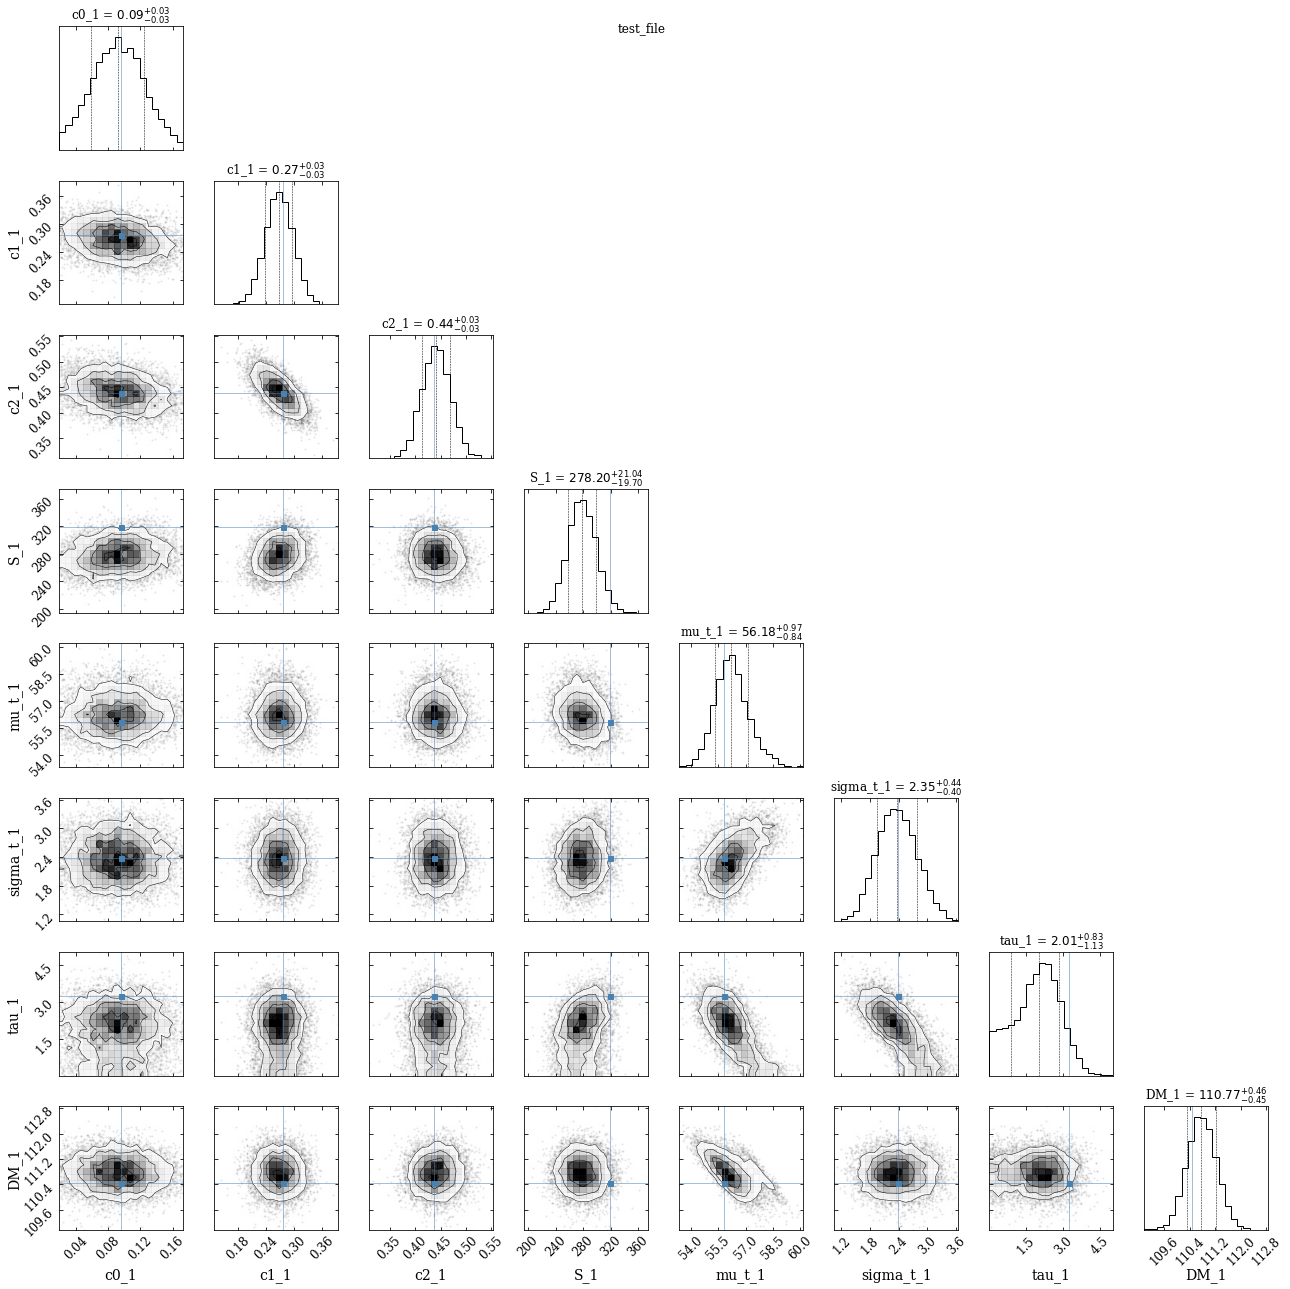

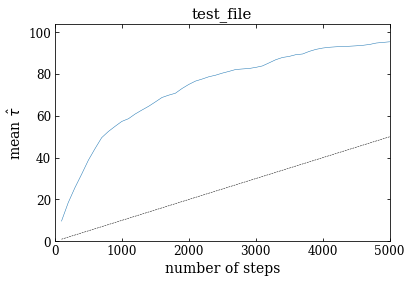

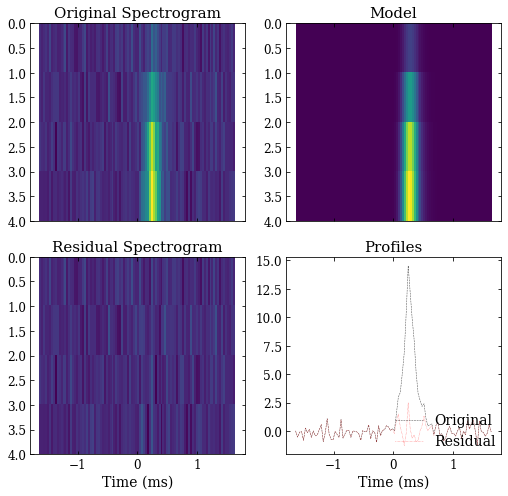

{bf}.bic =  99.74350609409663


0

In [32]:
fit_paper_mcmc_bic(bf_S1T2_c1, mcmc=True)

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-26 19:34:09,938 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 19:34:09,941 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 19:34:09,948 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-26 19:34:09,950 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-26 19:34:09,955 - tests -root - INFO - P values: T-test (0.35209), Kruskal (0.24800), KS (0.28267), F-test (0.08019)
2022-05-26 19:34:09,958 - run_tests -burstfit.fit - INFO - On pulse residual is similar to left off pulse region.
2022-05-26 19:34:09,960 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-26 19:34:09,966 - tests -root - INFO - P values: T-test (0.79841), Kruskal (0.59951), KS (0.66014), F-test (0.34593)
2022-05-26 19:34:09,968 - run_tests -burstfit.fit - INFO - On pulse residual is similar to right off pulse region.
2022-0

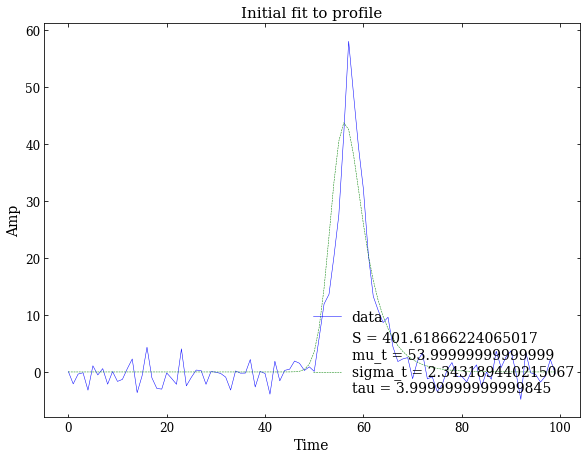

2022-05-26 19:34:10,183 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-26 19:34:10,186 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7ff3f19cad90>
[0.08549967 0.27269894 0.43279794 0.50350654]


2022-05-26 19:34:10,194 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-26 19:34:10,196 - initial_spectrafit -burstfit.fit - INFO - c0: 0.08549966663122177 +- 0.0
2022-05-26 19:34:10,198 - initial_spectrafit -burstfit.fit - INFO - c1: 0.27269893884658813 +- 0.0
2022-05-26 19:34:10,200 - initial_spectrafit -burstfit.fit - INFO - c2: 0.43279793858528137 +- 0.0


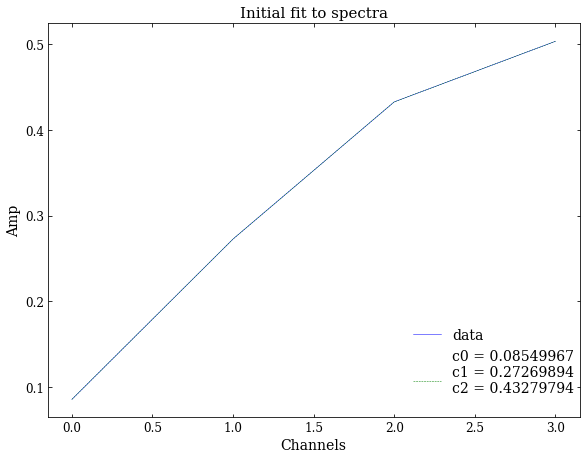

2022-05-26 19:34:10,366 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-26 19:34:10,369 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.08549967, 0.27269894, 0.43279794, 401.61866224065017, 53.99999999999999, 2.343189440215067, 3.9999999999999845, 111]
2022-05-26 19:34:10,545 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-26 19:34:10,549 - sgram_fit -burstfit.fit - INFO - c0: 0.09596833097525385 +- 0.012204508261721635
2022-05-26 19:34:10,551 - sgram_fit -burstfit.fit - INFO - c1: 0.2768666838072259 +- 0.01075549537638858
2022-05-26 19:34:10,554 - sgram_fit -burstfit.fit - INFO - c2: 0.4380179567016678 +- 0.010402486612516365
2022-05-26 19:34:10,557 - sgram_fit -burstfit.fit - INFO - S: 319.55386430320664 +- 3.528268069017978
2022-05-26 19:34:10,558 - sgram_fit -burstfit.fit - INFO - mu_t: 55.82603013641112 +- 0.2392820578440146
2022-05-26 19:34:10,560 - sgram_fit -burstfit.fit - INFO - sigma_t: 2.389055

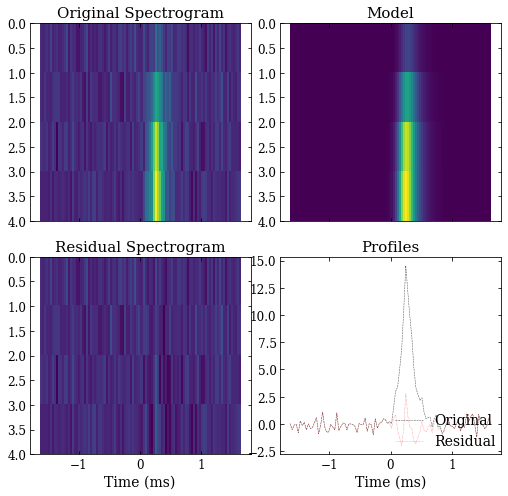

2022-05-26 19:34:10,938 - model -burstfit.fit - INFO - Making model.
2022-05-26 19:34:10,941 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 19:34:10,944 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 19:34:10,947 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-26 19:34:10,949 - model -burstfit.fit - INFO - Making model.
2022-05-26 19:34:10,951 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 19:34:10,954 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.4815666350582255
2022-05-26 19:34:10,956 - fitcycle -burstfit.fit - INFO - Fitting component 2.
2022-05-26 19:34:10,958 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 2
2022-05-26 19:34:10,986 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-05-26 19:34:10,988 - initial_profilefit -burs

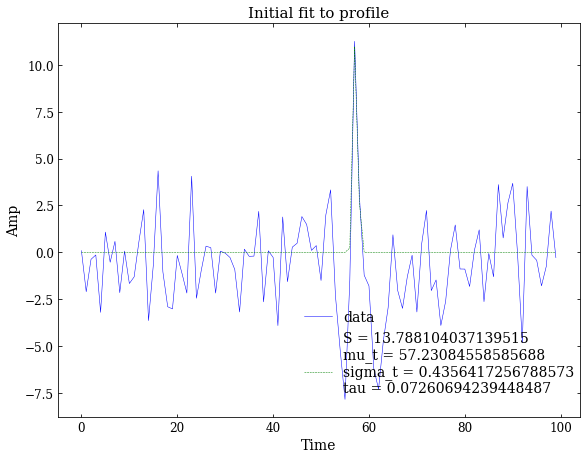

2022-05-26 19:34:11,133 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-26 19:34:11,137 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 2


<function model_free_normalized_4 at 0x7ff3f19cad90>
[-0.013001800018250274 0.15768484916405753 0.5401385990680866
 0.617354903553962]


2022-05-26 19:34:11,144 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-26 19:34:11,146 - initial_spectrafit -burstfit.fit - INFO - c0: -0.013001800018250274 +- 0.0
2022-05-26 19:34:11,147 - initial_spectrafit -burstfit.fit - INFO - c1: 0.15768484916405753 +- 0.0
2022-05-26 19:34:11,149 - initial_spectrafit -burstfit.fit - INFO - c2: 0.5401385990680866 +- 0.0


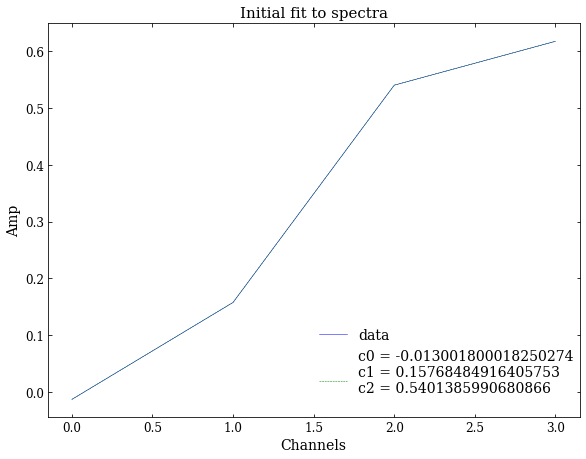

2022-05-26 19:34:11,283 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 2
2022-05-26 19:34:11,286 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [-0.013001800018250274, 0.15768484916405753, 0.5401385990680866, 13.788104037139515, 57.23084558585688, 0.4356417256788573, 0.07260694239448487, 111]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2022-05-26 19:34:11,318 - run_fit -burstfit.curvefit - WARNING - Fit errors are not finite. Retrying with p0+-(0.2*p0) bounds
2022-05-26 19:34:11,399 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-26 19:34:11,401 - sgram_fit -burstfit.fit - INFO - c0: -0.011573468347210628 +- 0.10794930703313346
2022-05-26 19:34:11,404 - sgram_fit -burstfit.fit - INFO - c1: 0.1736983184100272 +- 0.12612711734317977
2022-05-26 19:34:11,407 - sgram_fit -burstf

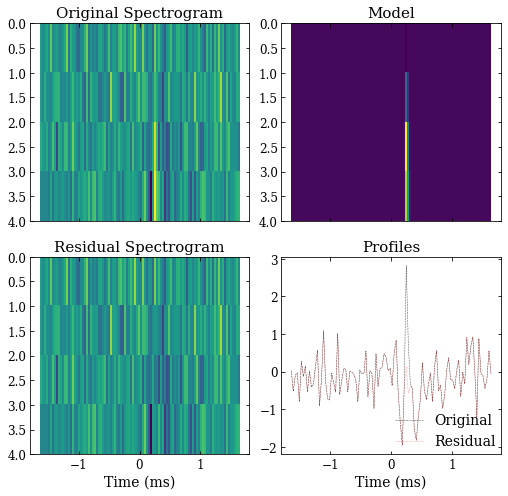

2022-05-26 19:34:11,729 - model -burstfit.fit - INFO - Making model.
2022-05-26 19:34:11,731 - model -burstfit.fit - INFO - Found 2 components.
2022-05-26 19:34:11,735 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 19:34:11,738 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-26 19:34:11,740 - model -burstfit.fit - INFO - Making model.
2022-05-26 19:34:11,741 - model -burstfit.fit - INFO - Found 2 components.
2022-05-26 19:34:11,745 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.4153714354223128
2022-05-26 19:34:11,747 - fitall -burstfit.fit - INFO - Fixed component exceeded. Terminated individual component fitting.
2022-05-26 19:34:11,749 - fitall -burstfit.fit - INFO - Final number of components 2 > 1. Fitting all components together.
2022-05-26 19:34:11,751 - fit_all_components -burstfit.fit - INFO - Fitting 2 components together.
2022-

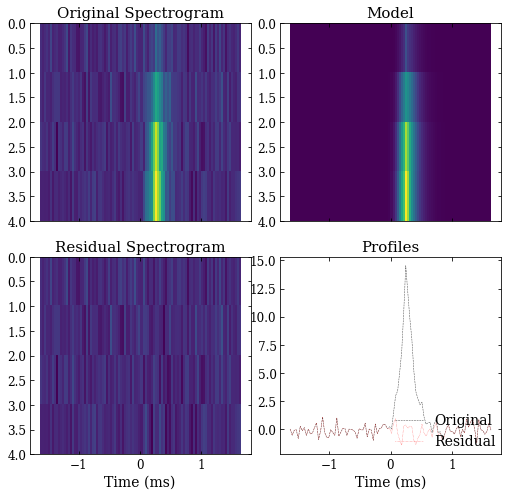

2022-05-26 19:34:12,467 - model -burstfit.fit - INFO - Making model.
2022-05-26 19:34:12,470 - model -burstfit.fit - INFO - Found 2 components.
2022-05-26 19:34:12,474 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 19:34:12,477 - get_off_pulse_region -burstfit.fit - INFO - Using sgram all-component-fit parameters.
2022-05-26 19:34:12,479 - model -burstfit.fit - INFO - Making model.
2022-05-26 19:34:12,480 - model -burstfit.fit - INFO - Found 2 components.
2022-05-26 19:34:12,484 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.2979589443712936
2022-05-26 19:34:12,486 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 19:34:12,488 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 19:34:12,492 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-26 19:3

{bf}.calc_redchisq()= 1.2979589443712936


In [33]:
bf_S1T2_c2 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t', 'tau'], pulse_fn, 
          [(0, 45, 0, 0),(np.inf, 65, 10*bd.width, np.inf)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, fix_ncomp = True, ncomp=2, plot=True)

2022-05-26 19:34:12,535 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-26 19:34:12,538 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [9.11645499e-02 2.87992614e-01 4.36999021e-01 2.97772037e+02
 5.57580842e+01 2.38385992e+00 3.19667547e+00 1.10496072e+02
 1.82840609e-01 1.10257886e-01 4.28504291e-01 1.34521032e+01
 5.71375147e+01 4.43971182e-01 7.09581643e-02 1.11147729e+02]
2022-05-26 19:34:12,540 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-26 19:34:12,543 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-05-26 19:34:12,545 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-26 19:34:12,547 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(5.754015846861241) + max_sigma_t_prior(4.290947852033187))
2022-05-26 19:34:12,54

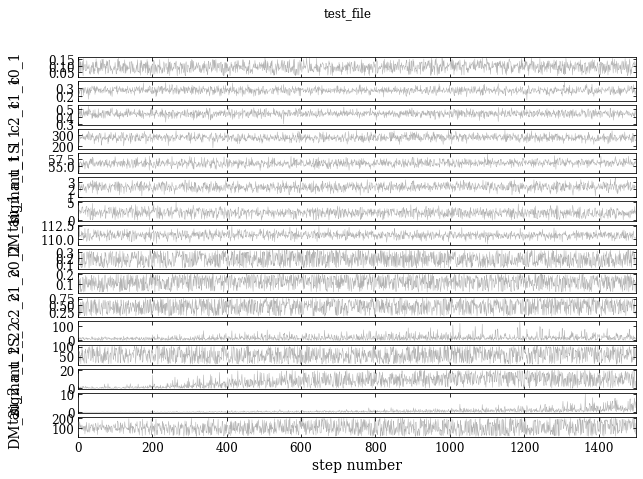

<Figure size 432x288 with 0 Axes>

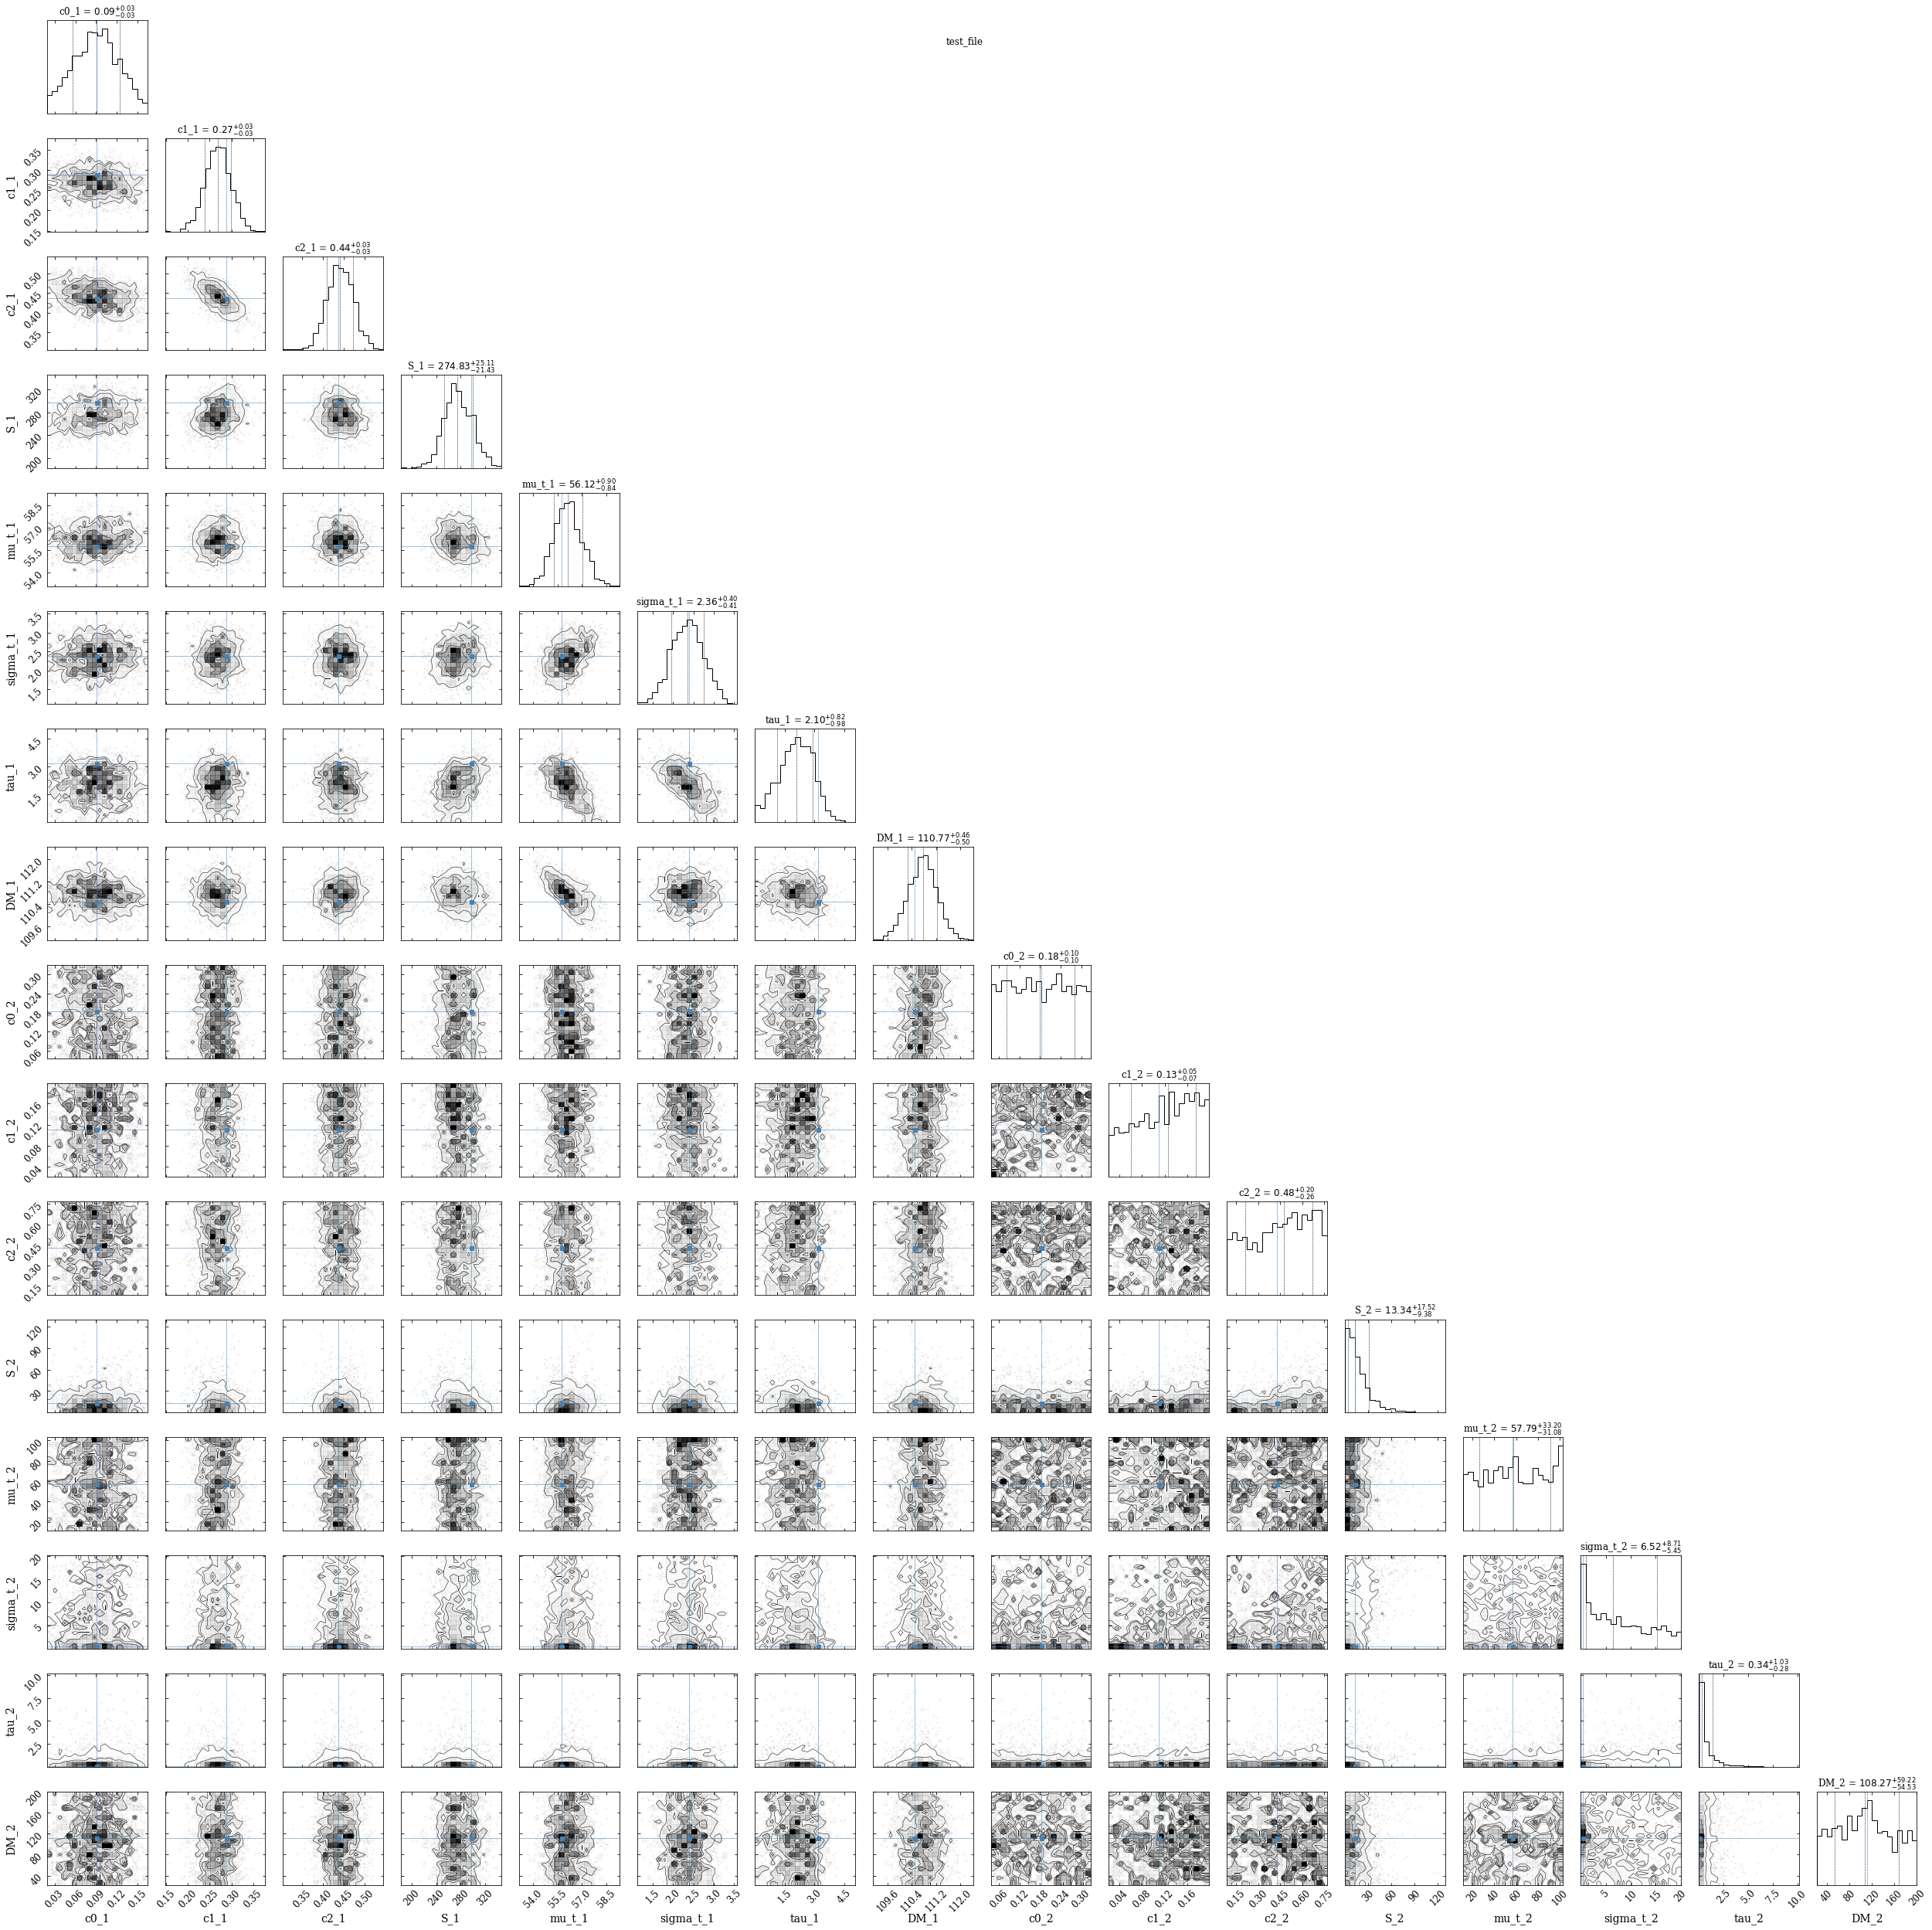

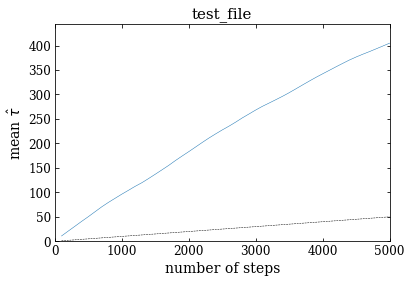

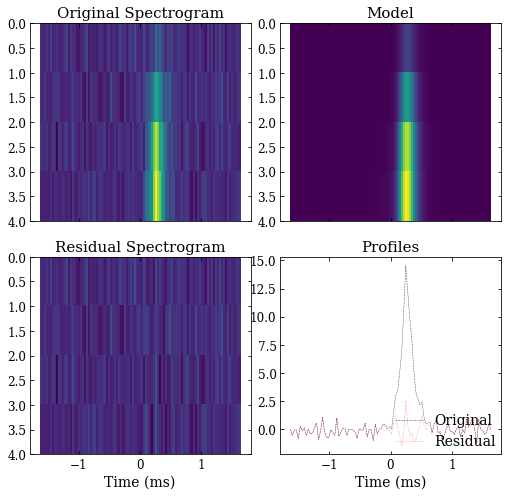

{bf}.bic =  140.3279434981573


0

In [34]:
fit_paper_mcmc_bic(bf_S1T2_c2, mcmc=True)

In [52]:
select_model(["bf_S1T2_c1", "bf_S1T2_c2"])


(['bf_S1T2_c1', 'bf_S1T2_c2'], array([ 99.74350609, 140.3279435 ]))

### bf_S1T1_cx: model-free spectrum + gaussian profile NO scattering + x-component 

self.function_input_names:  ['S', 'mu', 'sigma']
snames: ['c0', 'c1', 'c2', 'c3']
self.function_input_names:  ['c0', 'c1', 'c2', 'c3']


2022-05-24 23:57:22,384 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-05-24 23:57:22,385 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-24 23:57:22,394 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-05-24 23:57:22,396 - initial_profilefit -burstfit.fit - INFO - S: 351.11780034343604 +- 9.768018730464474
2022-05-24 23:57:22,397 - initial_profilefit -burstfit.fit - INFO - mu_t: 57.52700623189911 +- 0.09143216627680778
2022-05-24 23:57:22,400 - initial_profilefit -burstfit.fit - INFO - sigma_t: 2.846269428416982 +- 0.09143216794812181


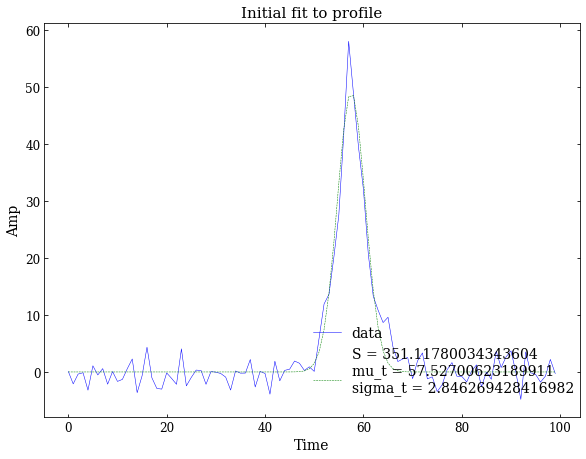

2022-05-24 23:57:22,546 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-24 23:57:22,548 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_4 at 0x7f4cebb4aea0>
[0.09705494 0.26526412 0.44478154 0.48285386]


2022-05-24 23:57:22,552 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-24 23:57:22,554 - initial_spectrafit -burstfit.fit - INFO - c0: 0.09705493599176407 +- 0.0
2022-05-24 23:57:22,555 - initial_spectrafit -burstfit.fit - INFO - c1: 0.2652641236782074 +- 0.0
2022-05-24 23:57:22,556 - initial_spectrafit -burstfit.fit - INFO - c2: 0.4447815418243408 +- 0.0
2022-05-24 23:57:22,558 - initial_spectrafit -burstfit.fit - INFO - c3: 0.48285385966300964 +- 0.0


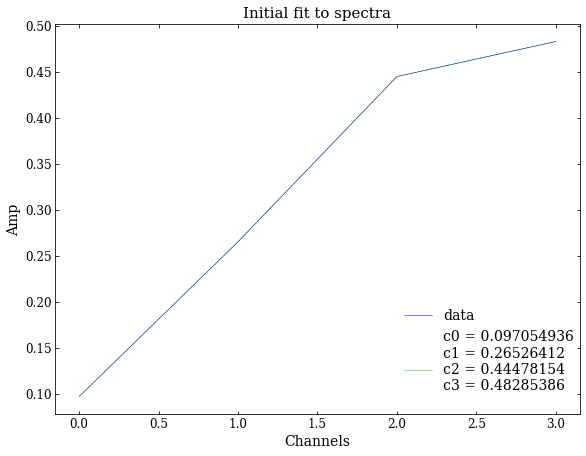

2022-05-24 23:57:22,716 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-24 23:57:22,718 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.097054936, 0.26526412, 0.44478154, 0.48285386, 351.11780034343604, 57.52700623189911, 2.846269428416982, 111]
2022-05-24 23:57:22,779 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-24 23:57:22,789 - sgram_fit -burstfit.fit - INFO - c0: 0.06086005109305386 +- 0.008390461533299438
2022-05-24 23:57:22,791 - sgram_fit -burstfit.fit - INFO - c1: 0.17498283670302525 +- 0.009227141886811325
2022-05-24 23:57:22,793 - sgram_fit -burstfit.fit - INFO - c2: 0.2868902774243371 +- 0.010578460621123458
2022-05-24 23:57:22,794 - sgram_fit -burstfit.fit - INFO - c3: 0.31825181884290754 +- 0.01089494486730017
2022-05-24 23:57:22,796 - sgram_fit -burstfit.fit - INFO - S: 413.41757803542407 +- 6.557223686599994
2022-05-24 23:57:22,798 - sgram_fit -burstfit.fit - INFO - mu_t: 57.915762052294

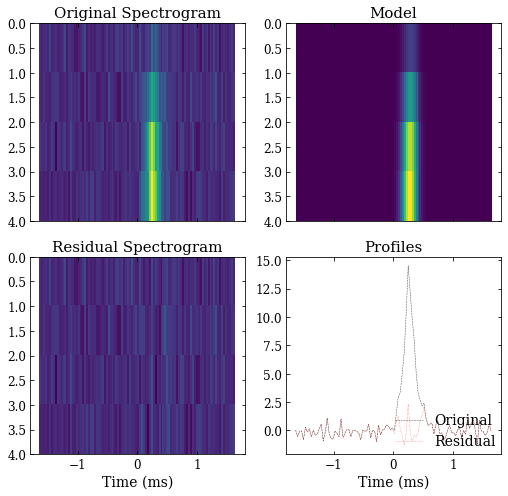

2022-05-24 23:57:23,545 - model -burstfit.fit - INFO - Making model.
2022-05-24 23:57:23,548 - model -burstfit.fit - INFO - Found 1 components.
2022-05-24 23:57:23,552 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-24 23:57:23,554 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-24 23:57:23,556 - model -burstfit.fit - INFO - Making model.
2022-05-24 23:57:23,558 - model -burstfit.fit - INFO - Found 1 components.
2022-05-24 23:57:23,561 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.3761991724457614
2022-05-24 23:57:23,564 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-24 23:57:23,566 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-24 23:57:23,570 - tests -root - INFO - P values: T-test (0.18051), Kruskal (0.14148), KS (0.28267), F-test (0.15210)
2022-05-24 23:57:23,572 - run

bf_S1T1_c1.calc_redchisq()= 1.3761991724457614


In [21]:
# bf_S1T1_c1: single component 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel

ncomp = 1 

pnames = ['S', 'mu_t', 'sigma_t'] # , 'tau'
pulseModel = Model(gauss, param_names=pnames)
#profile_bounds=[(0, 0.5 / bd.tsamp - i_low, 0),(np.inf, 0.52/ bd.tsamp - i_low, 5*bd.width)]
profile_bounds=[(0, 50, 0),(np.inf, 60, 5*bd.width)]


nfreq = 4
# For spectrum, try model-free  
nfreq_model = nfreq # try less 
snames = [0] * nfreq_model

for i in range(nfreq_model):
    snames[i] = 'c'+str(i)

print('snames:', snames)
spectraModel = Model(model_free_4, param_names=snames)
#spectraModel = Model(model_free, param_names=snames)





sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf)) # did not work when only set up bounds but do not chop data 
#sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf))

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T1_c1 for later model selection 
bf_S1T1_c1 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1, 
)


# Some setting up before we do the fitting 
bf_S1T1_c1.validate()
bf_S1T1_c1.precalc()


# fit tests
#bf_S1T1_c1.initial_profilefit(bounds = profile_bounds, plot = True)
#bf_S1T1_c1.initial_spectrafit(plot = True)

bf_S1T1_c1.fitcycle(plot=True, profile_bounds = profile_bounds) # fit for one component.
bf_S1T1_c1.fitall(plot=True, max_ncomp = ncomp) # fit all componnts 
print('bf_S1T1_c1.calc_redchisq()=', bf_S1T1_c1.calc_redchisq())

# plot fit for all components 
# plot_fit_results(bf_S1T1_c1.sgram, bf_S1T1_c1.sgram_model.evaluate, bf_S1T1_c1.sgram_params['all'][1]['popt'], 
#                  bf_S1T1_c1.tsamp, bf_S1T1_c1.fch1, bf_S1T1_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf_S1T1_c1.sgram_params['all'][1]['popt'][-1], bf_S1T1_c1.sgram_params['all'][1]['perr'][-1]

#bf_S1T1_c1.sgram_params

self.function_input_names:  ['S', 'mu', 'sigma']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-26 01:40:10,623 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-26 01:40:10,637 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-05-26 01:40:10,639 - initial_profilefit -burstfit.fit - INFO - S: 351.11780034343604 +- 9.768018730464474
2022-05-26 01:40:10,642 - initial_profilefit -burstfit.fit - INFO - mu_t: 57.52700623189911 +- 0.09143216627680778
2022-05-26 01:40:10,644 - initial_profilefit -burstfit.fit - INFO - sigma_t: 2.846269428416982 +- 0.09143216794812181


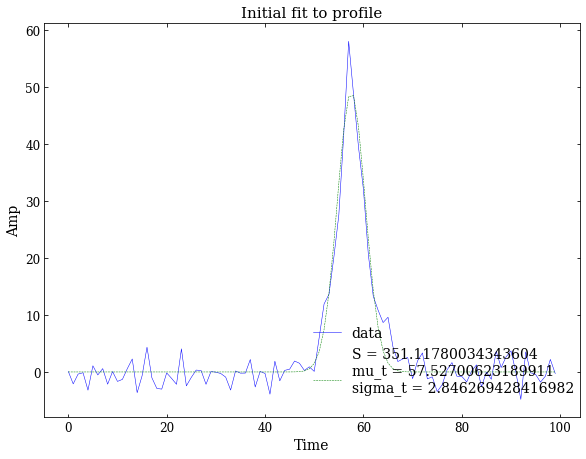

2022-05-26 01:40:10,830 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 01:40:10,833 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.


ValueError: zero-size array to reduction operation minimum which has no identity

In [9]:
# bf_S1T1_c1: single component 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel

ncomp = 1 
nfreq=4

pnames = ['S', 'mu_t', 'sigma_t'] 
pulseModel = Model(gauss, param_names=pnames)
profile_bounds=[(0, 50, 0),(np.inf, 60, 5*bd.width)]


snames = ['c0', 'c1', 'c2'] 
spectraModel = Model(model_free_normalized_4, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf)) # did not work when only set up bounds but do not chop data 
#sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf))

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T1_c1 for later model selection 
bf_S1T1_c1 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1, 
)


# Some setting up before we do the fitting 
bf_S1T1_c1.validate()
bf_S1T1_c1.precalc()


# fit tests
bf_S1T1_c1.initial_profilefit(bounds = profile_bounds, plot = True)
#bf_S1T1_c1.initial_spectrafit(plot = True)

#bf_S1T1_c1.fitcycle(plot=True, profile_bounds = profile_bounds) # fit for one component.
#bf_S1T1_c1.fitall(plot=True, max_ncomp = ncomp) # fit all componnts 
print('bf_S1T1_c1.calc_redchisq()=', bf_S1T1_c1.calc_redchisq())

# plot fit for all components 
# plot_fit_results(bf_S1T1_c1.sgram, bf_S1T1_c1.sgram_model.evaluate, bf_S1T1_c1.sgram_params['all'][1]['popt'], 
#                  bf_S1T1_c1.tsamp, bf_S1T1_c1.fch1, bf_S1T1_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf_S1T1_c1.sgram_params['all'][1]['popt'][-1], bf_S1T1_c1.sgram_params['all'][1]['perr'][-1]

#bf_S1T1_c1.sgram_params

In [16]:
# bf_S1T2_c2: model-free spectrum + gaussian with scattering profile (2 components) 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)
#profile_bounds=[(0, 480, 0, 0),(np.inf, 510, 10*bd.width, np.inf)]
profile_bounds=[(0, 50, 0),(np.inf, 60, 5*bd.width)]

nfreq = 4
# For spectrum, try model-free  
nfreq_model = nfreq # try less 
snames = [0] * nfreq_model

for i in range(nfreq_model):
    snames[i] = 'c'+str(i)

print('snames:', snames)
spectraModel = Model(model_free_4, param_names=snames)
#spectraModel = Model(model_free, param_names=snames)





sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((0, 0.45, 0, -np.inf),(np.inf, 0.55, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T2_c2 for later model selection 
bf_S1T2_c2 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    comp_num = 2, 
)


# Some setting up before we do the fitting 
bf_S1T2_c2.validate()
bf_S1T2_c2.precalc()


# fit 
#bf_S1T2_c2.initial_profilefit(bounds = profile_bounds, plot = True)
#bf_S1T2_c2.initial_spectrafit(plot = True)

bf_S1T2_c2.fitcycle(plot = True)
# fit all componnts 
bf_S1T2_c2.fitall(plot = True, max_ncomp = bf_S1T2_c2.comp_num + 1) 
bf_S1T2_c2.calc_redchisq()
plot_fit_results(bf_S1T2_c2.sgram, bf_S1T2_c2.sgram_model.evaluate, bf_S1T2_c2.sgram_params['all'][1]['popt'], 
                 bf_S1T2_c2.tsamp, bf_S1T2_c2.fch1, bf_S1T2_c2.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf_S1T2_c2.sgram_params['all'][1]['popt'][-1], bf_S1T2_c2.sgram_params['all'][1]['perr'][-1]

bf_S1T2_c2.sgram_params

NameError: name 'pulse_fn_vec' is not defined